In [13]:
import torch
from uci import UCIDataset
from base import train
from ddn import DDN

EPOCHS = 500
BATCH_SIZE = 256
LR = 3e-4
device = torch.device('cuda')
SPLIT_RATIO = 0.7

In [14]:
dataset = UCIDataset('energy') 
data = dataset.data
data = (data - torch.mean(data, dim=0)) / torch.std(data, dim=0)
targets = dataset.targets

In [15]:
def split_train_test(train_size, test_size):
    perm = torch.randperm(train_size + test_size)
    train_idx = perm[:train_size]
    test_idx = perm[train_size:]
    return train_idx, test_idx

In [16]:
train_size = int(dataset.data.shape[0] * SPLIT_RATIO)
test_size = dataset.data.shape[0] - train_size
train_idx, test_idx = split_train_test(train_size, test_size)
train_X, train_Y, test_X, test_Y = data[train_idx], targets[train_idx],  data[test_idx], targets[test_idx]

In [18]:
condition_dim = train_X.shape[1]
target_dim = train_Y.shape[1]
targets = torch.cat([train_Y, test_Y], dim=0)

targets_range = torch.stack(
    [torch.floor(targets.min(dim=0)[0]) - 1, 
    torch.ceil(targets.max(dim=0)[0]) + 1]).T.tolist()

In [19]:
net = DDN(
    num_perm=5, 
    condition_dim=condition_dim, 
    target_dim=target_dim, 
    target_range_list=targets_range, 
    codes=16, 
    channels=4, 
    width=4, 
    beta=0.025, 
    estimator_channels_list=[32, 16],
    scale_factor=4
)      

In [20]:
train(net, train_X, train_Y, device, EPOCHS, BATCH_SIZE, LR)
logprobs = net.conditional_logprobs(test_X.to(device), test_Y.to(device)).cpu()
print(logprobs.mean().item(), logprobs.std().item())

100%|██████████| 500/500 [00:43<00:00, 11.55it/s]


-3.3567025661468506 1.450001835823059


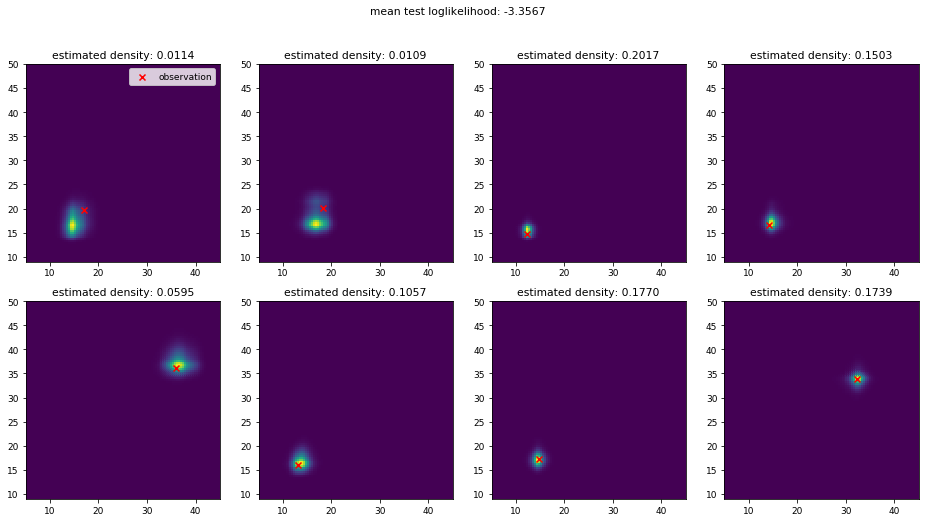

In [28]:
if target_dim == 2:
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D

    y0 = torch.linspace(targets_range[0][0], targets_range[0][1], 100)
    y1 = torch.linspace(targets_range[1][0], targets_range[1][1], 100)
    y0, y1 = torch.meshgrid([y0, y1])
    y = torch.vstack([y0.flatten(), y1.flatten()]).T
    y = y.to(device)
    fig = plt.figure(figsize=(16, 8))
    plt.rcParams.update({'font.size': 9})
    for i, (x, y_gt) in enumerate(zip(test_X[:8], test_Y[:8])):
        ax = fig.add_subplot(2, 4, i + 1)
        x = x.unsqueeze(0).expand(100**2, -1).to(device)

        probs_list = []            
        Xs = torch.split(x, 1000, dim=0)
        Ys = torch.split(y, 1000, dim=0)
        for _, (x_, y_) in enumerate(zip(Xs, Ys)):
            probs = net.conditional_logprobs(x_, y_).exp().cpu()
            probs_list.append(probs)
        probs = torch.stack(probs_list)
        ax.pcolor(y0, y1, probs.cpu().reshape(100, 100), vmin=0, label='_nolegend_')
        ax.set_title('estimated density: %.4f' % (logprobs[i].exp()))
        ax.scatter(y_gt[0], y_gt[1], marker='x', c='r')
        plt.suptitle('mean test loglikelihood: %.4f' % logprobs.mean())
        if i == 0:
            plt.legend(['observation'])
    plt.show()